In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimensions: (1080, 1920, 3)


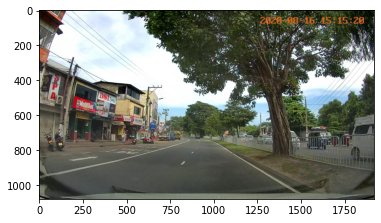

In [3]:
#reading in an image
image = mpimg.imread('/content/drive/MyDrive/Self-driving/Finding lane lines/images/120.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    #for line in lines:
        #for x1,y1,x2,y2 in line:
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)

    x_left_lane = []
    y_left_lane = []
    x_right_lane = []
    y_right_lane = []
    ytop = int(350) # need y coordinates of the top and bottom of left and right lane
    ybtm = int(540) #  to calculate x values once a line is found
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = float(((y2-y1)/(x2-x1)))
            if (slope > 0.3): # if the line slope is greater than 0, it is the left lane
                    x_left_lane.append(x1)
                    x_left_lane.append(x2)
                    y_left_lane.append(y1)
                    y_left_lane.append(y2)
                    
            if (slope < -0.3): # if the line slope is less than 0, it is the right lane
                    x_right_lane.append(x1)
                    x_right_lane.append(x2)
                    y_right_lane.append(y1)
                    y_right_lane.append(y2)
                    
    
    # only execute if there are points found that meet criteria
    if (x_left_lane!=[]) & (x_right_lane!=[]) & (y_left_lane!=[]) & (y_right_lane!=[]): 
        left_line_coeffs = (np.polyfit(x_left_lane, y_left_lane, 1))
        left_xtop = int((ytop - left_line_coeffs[1])/left_line_coeffs[0])
        left_xbtm = int((ybtm - left_line_coeffs[1])/left_line_coeffs[0])
        
        cv2.line(img, (left_xtop, ytop), (left_xbtm, ybtm), color, thickness)
        
        right_line_coeffs = np.polyfit(x_right_lane, y_right_lane, 1)
        right_xtop = int((ytop - right_line_coeffs[1])/right_line_coeffs[0])
        right_xbtm = int((ybtm - right_line_coeffs[1])/right_line_coeffs[0])
       
        cv2.line(img, (right_xtop, ytop), (right_xbtm, ybtm), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [5]:
import os
test_images_list = os.listdir("/content/drive/MyDrive/Self-driving/Finding lane lines/test_images/") # modified a little to save filenames of test images

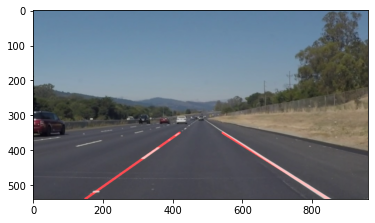

In [6]:
# Building a pipeline that will draw lane lines on the test_images
for test_image in test_images_list: # iterating through the images in test_images folder
    
    #CONVERT THE IMAGE FROM RGB TO HSL COLORSPACE
    #for test_image in test_images_list: # iterating through the images in test_images folder
    image = mpimg.imread('/content/drive/MyDrive/Self-driving/Finding lane lines/test_images/' + test_image) # reading in an image
    #hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV) # HSV conversion
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS) # HSL conversion
    

    #APPLY A GAUSSIAN FILTER FOR SMOOTHING OF LANE LINES
    # Define a kernel size for Gaussian smoothing / blurring 
    # Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
    kernel_size = 3
    blur_hls = cv2.GaussianBlur(hls,(kernel_size, kernel_size), 0)

    # DEFINE PARAMETERS FOR CANNY EDGE DETECTOR / RATIO OF 1:3 FOR LOW TO HIGH THRESHOLD
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blur_hls, low_threshold, high_threshold)

    # CREATE A MASKED IMAGE OF OUR CANNY FILTER OUTPUT IMAGE'edges' 
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   
    # Defining a four-sided polygon region to mask, using full length of bottom of image and \top verticies are defined to capture lanes in distance
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(390, 350), (580,350), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = cv2.fillPoly(mask, vertices, ignore_mask_color) # retain information only in the region of interest
    

    # DEFINE PARAMETERS FOR HOUGH TRANSFORM
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20 # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 15 # minimum number of pixels making up a line
    max_line_gap = 25   # maximum gap in pixels between connectable line segments

    # Utilize output of Hough Transform and return a masked image 'line_image' with red Hough Lines drawn
    masked_edges = region_of_interest(edges, vertices) # retain information only in the region of interest
    line_image = hough_lines(masked_edges, rho, theta, threshold,\
                                 min_line_length, max_line_gap)

    # CREATE A "COLOR" IMAGE COMBINNG THE ORIGNAL IMAGE WITH THE PROCESSED IMAGE 'line_image'
    final_img = weighted_img(line_image, image, α=0.8, β=1.)

    #Display the image
    plt.imshow(final_img)

    # then save them to the test_images_output directory.
    mpimg.imsave('/content/drive/MyDrive/Self-driving/Finding lane lines/test_pipeline_images/' + test_image, final_img) # save the resulting image

In [7]:
!pip install imageio==2.4.1

import imageio
imageio.plugins.ffmpeg.download()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 57.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for imageio: filename=imageio-2.4.1-py3-none-any.whl size=3303886 sha256=5a51a89e6a2037587600d72e1484bf32571938c89fb483d659fdac7e9c15974c
  Stored in directory: /root/.cache/pip/wheels/be/7b/04/4d8d56f1d503e5c404f0de6018c0cfa592c71588a39b49e002
Successfully built imageio
  Attempting uninstall: imageio
    Found existing installation: imageio 2.9.0
    Uninstalling imageio-2.9.0:
      Successfully uninstalled imageio-2.9.0
Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3063808/45929032 bytes (6.7%)6455296/459290

In [8]:
#Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [9]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO:
   
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS) # HSL conversion
    #hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV) # HSV conversion

    #APPLY A GAUSSIAN FILTER FOR SMOOTHING OF LANE LINES
    # Define a kernel size for Gaussian smoothing / blurring 
    # Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
    kernel_size = 3
    blur_hls = cv2.GaussianBlur(hls,(kernel_size, kernel_size), 0)

    # DEFINE PARAMETERS FOR CANNY EDGE DETECTOR / RATIO OF 1:3 FOR LOW TO HIGH THRESHOLD
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blur_hls, low_threshold, high_threshold)

    # CREATE A MASKED IMAGE OF OUR CANNY FILTER OUTPUT IMAGE'edges' 
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   
    # Defining a four-sided polygon region to mask, using full length of bottom of image and \top verticies are defined to capture lanes in distance
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(390, 350), (580,350), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = cv2.fillPoly(mask, vertices, ignore_mask_color) # retain information only in the region of interest
    

    # DEFINE PARAMETERS FOR HOUGH TRANSFORM
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20 # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 15 # minimum number of pixels making up a line
    max_line_gap = 25   # maximum gap in pixels between connectable line segments

    # Utilize output of Hough Transform and return a masked image 'line_image' with red Hough Lines drawn
    masked_edges = region_of_interest(edges, vertices) # retain information only in the region of interest
    line_image = hough_lines(masked_edges, rho, theta, threshold,\
                                 min_line_length, max_line_gap)

    # CREATE A "COLOR" IMAGE COMBINNG THE ORIGNAL IMAGE WITH THE PROCESSED IMAGE 'line_image'
    final_img = weighted_img(line_image, image, α=0.8, β=1.)

    return final_img

In [10]:
white_output = '/content/drive/MyDrive/Self-driving/Finding lane lines/test_videos/Output_solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("/content/drive/MyDrive/Self-driving/Finding lane lines/test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video /content/drive/MyDrive/Self-driving/Finding lane lines/test_videos/Output_solidWhiteRight.mp4
[MoviePy] Writing video /content/drive/MyDrive/Self-driving/Finding lane lines/test_videos/Output_solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:24<00:00,  9.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Self-driving/Finding lane lines/test_videos/Output_solidWhiteRight.mp4 

CPU times: user 5.84 s, sys: 404 ms, total: 6.25 s
Wall time: 27.2 s


In [11]:
yellow_output = '/content/drive/MyDrive/Self-driving/Finding lane lines/test_videos/Output_solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("/content/drive/MyDrive/Self-driving/Finding lane lines/test_videos/solidYellowLeft.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video /content/drive/MyDrive/Self-driving/Finding lane lines/test_videos/Output_solidYellowLeft.mp4
[MoviePy] Writing video /content/drive/MyDrive/Self-driving/Finding lane lines/test_videos/Output_solidYellowLeft.mp4


 15%|█▌        | 104/682 [00:05<00:42, 13.55it/s]WARNING:py.warnings:<ipython-input-4-7be4342b7a95>:77: RuntimeWarning: divide by zero encountered in int_scalars
  slope = float(((y2-y1)/(x2-x1)))

100%|█████████▉| 681/682 [00:47<00:00, 14.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Self-driving/Finding lane lines/test_videos/Output_solidYellowLeft.mp4 

CPU times: user 18.3 s, sys: 1.46 s, total: 19.8 s
Wall time: 50.4 s


In [12]:
challenge_output = '/content/drive/MyDrive/Self-driving/Finding lane lines/test_videos/Output_challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("/content/drive/MyDrive/Self-driving/Finding lane lines/test_videos/challenge.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(challenge_output, audio=False)

  slope = float(((y2-y1)/(x2-x1)))



[MoviePy] >>>> Building video /content/drive/MyDrive/Self-driving/Finding lane lines/test_videos/Output_challenge.mp4
[MoviePy] Writing video /content/drive/MyDrive/Self-driving/Finding lane lines/test_videos/Output_challenge.mp4


100%|██████████| 251/251 [00:38<00:00,  6.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Self-driving/Finding lane lines/test_videos/Output_challenge.mp4 

CPU times: user 16.7 s, sys: 790 ms, total: 17.5 s
Wall time: 41.7 s
